In [302]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import svm

In [10]:
#Q1
#We first import the toy data and see what it contains

toy_data = np.load('toy-data.npz')
print(toy_data.files)

['training_data', 'training_labels', 'test_data']


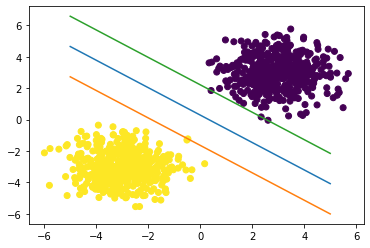

In [177]:
#Plotting data

plt.scatter(toy_data['training_data'][:,0], toy_data['training_data'][:,1], c = toy_data['training_labels'])

#Model parameters, given in question
w = np.array([-0.4528,-0.5190])
b = 0.1471

#Plotting decision bdy
x = np.linspace(-5, 5, 100)
y = -(w[0] * x + b) / w[1]
plt.plot(x, y)

#Plotting margins
y1_margin = (1 - b - w[0]*x) / w[1]
y2_margin = (-1 - b - w[0]*x) / w[1]

plt.plot(x,y1_margin)
plt.plot(x,y2_margin)

In [41]:
#Q2
#Again, load data

mnist_data = np.load('mnist-data.npz')
print(mnist_data.files)

spam_data = np.load('spam-data.npz')
print(spam_data.files)

['training_data', 'training_labels', 'test_data']
['training_data', 'training_labels', 'test_data']


In [280]:
#Partitioning data
perm = np.random.permutation(60000)
shuffled_data = mnist_data['training_data'][perm]
shuffled_labels = mnist_data['training_labels'][perm]

validation_data = shuffled_data[-10000:]
validation_labels = shuffled_labels[-10000:]

training_data = shuffled_data[:50000]
training_labels = shuffled_labels[:50000]

#Same for spam/ham
data_length = np.shape(spam_data['training_data'])[0]
bdy = int(np.floor(data_length/5))

perm2 = np.random.permutation(data_length)
shuffled_data2 = spam_data['training_data'][perm2]
shuffled_labels2 = spam_data['training_labels'][perm2]

validation_data2 = shuffled_data2[-bdy:]
validation_labels2 = shuffled_labels2[-bdy:]

training_data2 = shuffled_data2[:data_length-bdy]
training_labels2 = shuffled_labels2[:data_length-bdy]

In [260]:
#Evaluation metric
def acc(pred_labels, true_labels):
    n = np.shape(true_labels)[0]
    temp = 0
    for i in range(n):
        if pred_labels[i] == true_labels[i]:
            temp+=1
    return temp/n

In [352]:
#Q3
#Preprocessing step
#Vectorize & rescale the data
vector_data = training_data.reshape(50000,784)/256
vector_data_validation = validation_data.reshape(10000,784)/256

#Training step
training_size = np.array([100,200,500,1000,2000,5000,10000])
clf = svm.SVC(kernel = "linear")

training_acc = np.array([])
validation_acc = np.array([])

for i in training_size:
    clf.fit(vector_data[:i],training_labels[:i])
    
    training_preds = clf.predict(vector_data[:i])
    train_acc = acc(training_preds,training_labels[:i])
    
    val_preds = clf.predict(vector_data_validation)
    val_acc = acc(val_preds,validation_labels)
    
    training_acc = np.append(training_acc,train_acc)
    validation_acc= np.append(validation_acc,val_acc)

Text(0.5, 1.0, 'Accuracy for MNIST')

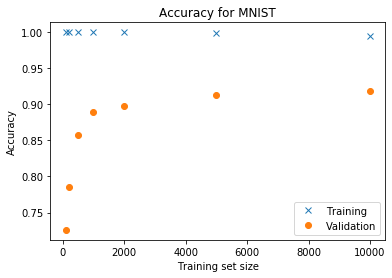

In [353]:
#Plotting accuracy 
plt.plot(training_size,training_acc,'x', label = "Training")
plt.plot(training_size,validation_acc,'o', label = "Validation")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for MNIST")

In [254]:
#Now do the same for spam/ham

#Training step
training_size = np.array([100,200,500,1000,2000,data_length])
clf = svm.SVC()

training_acc = np.array([])
validation_acc = np.array([])

for i in training_size:
    clf.fit(training_data2[:i],training_labels2[:i])
    
    training_preds = clf.predict(training_data2[:i])
    train_acc = acc(training_preds,training_labels2[:i])
    
    val_preds = clf.predict(validation_data2)
    val_acc = acc(val_preds,validation_labels2)
    
    training_acc = np.append(training_acc,train_acc)
    validation_acc= np.append(validation_acc,val_acc)

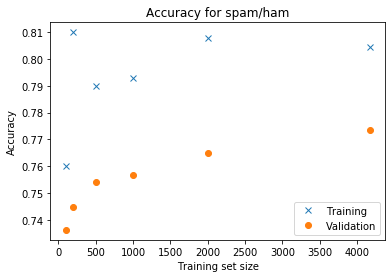

In [256]:
#Plotting accuracy 
plt.plot(training_size,training_acc,'x', label = "Training")
plt.plot(training_size,validation_acc,'o', label = "Validation")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.title("Accuracy for spam/ham")
plt.legend()

In [364]:
#Q4
#We will now tune the hyperparameter in soft-margin SVM


hyper_acc = np.array([])
C_range = np.reshape(10.0**np.array([range(-4,4)]),8)

for i in C_range:
    
    clf = svm.SVC(C=i, kernel = 'linear')
    clf.fit(vector_data[:10000],training_labels[:10000])
    
    val_preds = clf.predict(vector_data_validation)
    val_acc = acc(val_preds,validation_labels)
    
    hyper_acc = np.append(hyper_acc,val_acc)

Text(0.5, 1.0, 'Hyperparameter tuning')

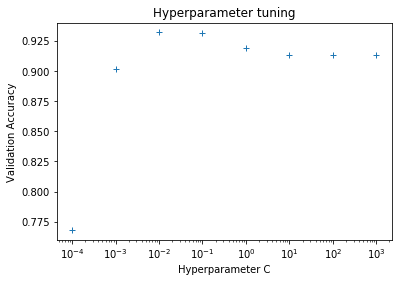

In [366]:
plt.plot(C_range,hyper_acc,'+')
plt.xscale('log')
plt.xlabel("Hyperparameter C")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter tuning")

In [514]:
#Q5
#Hyperparameter tuning in spam/ham using 5-fold cross validation

#First split the data set
split_data = np.array_split(shuffled_data2,5)
split_labels = np.array_split(shuffled_labels2,5)

#Training and validation sets
def training_set(i):
    
    if i != 0:
        temp = split_data[0]
        for j in range(1,5):
            if j != i:
                temp = np.append(temp,split_data[j], axis=0)
    else:
        temp = split_data[1]
        for j in range(2,5):
            temp = np.append(temp,split_data[j],axis=0)
        
            
    return temp

def training_labels(i):
    
    if i != 0:
        temp = split_labels[0]
        for j in range(1,5):
            if j != i:
                temp = np.append(temp,split_labels[j])
    else:
        temp = split_labels[1]
        for j in range(2,5):
            temp = np.append(temp,split_labels[j])
        
            
    return temp

def validation_set(i):
    return split_data[i]

def validation_labels(i):
    return split_labels[i]

#Keep track of accuracies
hyper_acc = np.array([])
C_range = np.reshape(4.0**np.array([range(-4,4)]),8)

#Check accuracies
for j in C_range:

    weighted_acc = 0
    for i in range(5):
    
        clf = svm.SVC(kernel = "linear",C=j)
        clf.fit(training_set(i),training_labels(i))
    
        preds = clf.predict(validation_set(i))
    
        weighted_acc += 1/5 * acc(preds,validation_labels(i))
    
    hyper_acc = np.append(hyper_acc,weighted_acc)

Text(0.5, 1.0, 'Hyperparameter tuning with 5-fold cross-validation')

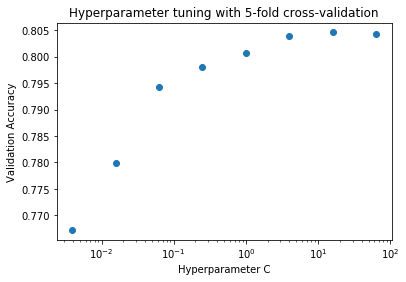

In [517]:
plt.plot(C_range,hyper_acc, 'o')
plt.xlabel("Hyperparameter C")
plt.xscale("log")
plt.ylabel("Validation Accuracy")
plt.title("Hyperparameter tuning with 5-fold cross-validation")